In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_excel("Online_Retail[1].xlsx", sheet_name="Online Retail")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df = df[df['InvoiceNo'].notnull()]
df = df[df['CustomerID'].notnull()]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
latest_date = df['InvoiceDate'].max()
print("Reference date:", latest_date)

Reference date: 2011-12-09 12:50:00


In [5]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


In [6]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,325,1,77183.60,1,1,5,115
1,12347.0,1,7,4310.00,5,5,5,555
2,12348.0,74,4,1797.24,2,4,4,244
3,12349.0,18,1,1757.55,4,1,4,414
4,12350.0,309,1,334.40,1,1,2,112


In [8]:
def segment_customer(row):
    if row['RFM_Score'] == '555':
        return 'Best Customer'
    elif row['R_Score'] == '5':
        return 'Recent Buyer'
    elif row['F_Score'] == '5':
        return 'Frequent Buyer'
    elif row['M_Score'] == '5':
        return 'High Value'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm['Segment'].value_counts()

Segment
Others           3990
Best Customer     348
Name: count, dtype: int64

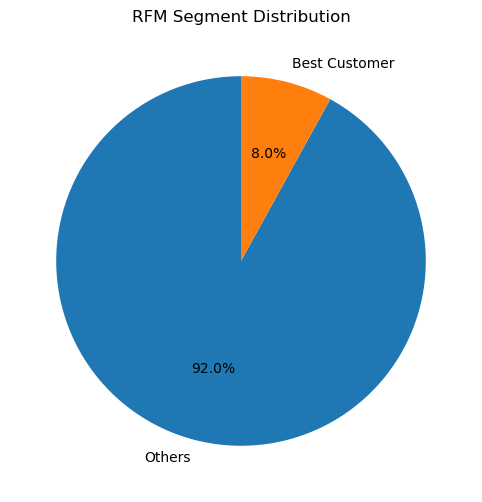

In [29]:
rfm_counts = rfm['Segment'].value_counts()
plt.figure(figsize=(8, 6))
rfm_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title("RFM Segment Distribution")
plt.show()

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
rfm_model = rfm[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_model)

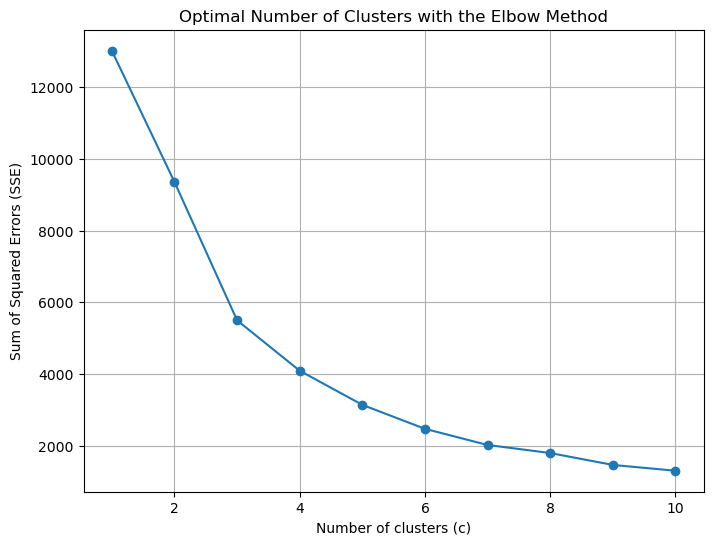

In [31]:
from sklearn.cluster import KMeans

sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel("Number of clusters (c)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Optimal Number of Clusters with the Elbow Method")
plt.grid()
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

rfm['Cluster'] = clusters

rfm['Cluster'].value_counts().sort_index()

Cluster
0    3054
1    1067
2      13
3     204
Name: count, dtype: int64

In [14]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

,Recency,Frequency,Monetary
Cluster,,,
0,42.7,3.7,1359.0
1,247.1,1.6,480.6
2,6.4,82.5,127338.3
3,14.5,22.3,12709.1


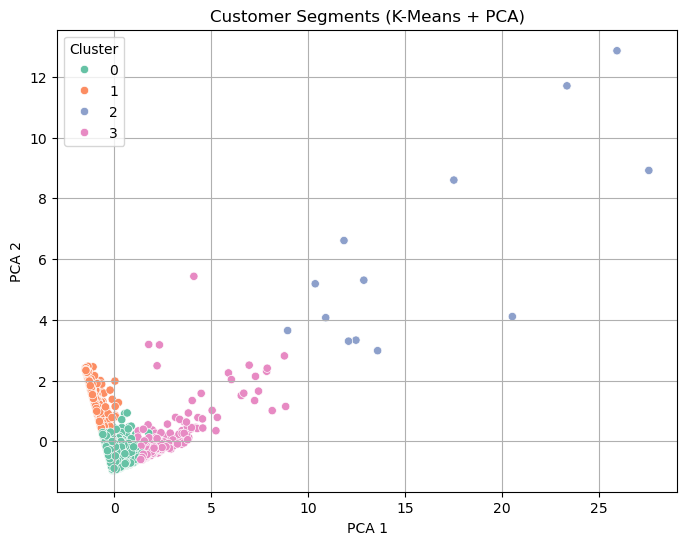

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=rfm['Cluster'], palette='Set2')
plt.title("Customer Segments (K-Means + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid()
plt.show()